In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
%%time

datasets = {
    'AmpC':'../data/AmpC_screen_table_1M/result_single_Morgan_size=2048_radius=2.csv',
    'D4'  :'../data/D4_screen_table_1M/result_single_Morgan_size=2048_radius=2.csv',
    '4eiy':'../data/4eiy_screen_table_1M/result_single_Morgan_size=2048_radius=2.csv',
    '5zty':'../data/5zty_screen_table_1M/result_single_Morgan_size=2048_radius=2.csv',
           }
dataset_size = {'AmpC':96214206, 'D4':138312677, '4eiy':int(1e6),'5zty':int(1e6)}

dfs = []
for name, path in tqdm(datasets.items()):
    df = pd.read_csv(path)
    df['proj'] = name
    df['N_ligands'] = dataset_size.get(name)
    dfs.append(df)

raw_data = pd.concat(dfs)

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 43.1 ms, sys: 2.45 ms, total: 45.5 ms
Wall time: 42.3 ms


In [3]:
print(raw_data.shape)
raw_data.sample(n=15)

(5747, 18)


,Unnamed: 0,model,type,top_threshold,train_size,accuracy_score,precision_score,recall_score,TP+FP,docked,time_sec,fingerprints,TP,TN,FP,FN,proj,N_ligands
1418,617,SVR,regressor,Hit(top 1.0%),40000,0.981600,0.080000,0.080000,100,40100,6649,Morgan,NaN,NaN,NaN,NaN,4eiy,1000000
1,1,MostFrequentDummyClassifier,classifier,Hit(top 5.0%),80000,0.951200,0.000000,0.000000,0,80000,34,Morgan,NaN,NaN,NaN,NaN,4eiy,1000000
167,167,RandomForestClassifier,classifier,Hit(top 0.5%),320000,0.992888,0.500000,0.003515,4,320004,336,Morgan,2.0,79429.0,2.0,567.0,D4,138312677
1155,1019,RandomForestRegressor,regressor,Hit(top 0.5%),80000,0.990900,0.090000,0.090000,100,80100,4204,Morgan,NaN,NaN,NaN,NaN,5zty,1000000
1165,364,RandomForestRegressor,regressor,Hit(top 5.0%),320000,0.929300,0.293000,0.293000,4000,324000,23802,Morgan,NaN,NaN,NaN,NaN,4eiy,1000000
520,384,KNeighborsRegressorWithOneNeighborJaccard,regressor,Hit(top 0.5%),40000,0.990000,0.000000,0.000000,50,40050,1851,Morgan,NaN,NaN,NaN,NaN,5zty,1000000
492,492,MostFrequentDummyClassifier,classifier,Hit(top 1.0%),320000,0.990100,0.000000,0.000000,0,320000,89,Morgan,NaN,NaN,NaN,NaN,4eiy,1000000
1025,625,LassoCV,regressor,Hit(top 0.5%),80000,0.992400,0.240000,0.240000,100,80100,482,Morgan,24.0,19824.0,76.0,76.0,AmpC,96214206
1099,963,RandomUniformRegressor,regressor,Hit(top 0.5%),80000,0.990000,0.000000,0.000000,100,80100,17,Morgan,NaN,NaN,NaN,NaN,5zty,1000000
14,14,RandomForestClassifier,classifier,Hit(top 0.5%),8000,0.994500,0.000000,0.000000,0,8000,20,Morgan,NaN,NaN,NaN,NaN,4eiy,1000000


In [4]:
def threshold2int(s: str) -> int:
    return float(s.replace('%',' ').split()[1])

def threshold_to_int(df: pd.DataFrame) -> pd.DataFrame:
    df['top_threshold'] = df.apply(
        {'top_threshold':threshold2int}
    )
    return df


def add_ratio(df: pd.DataFrame) -> pd.DataFrame:
    # D4 from "Ultra-large for discovering chemotypes"
    # around 1s per ligand
    sec_per_ligand = 43_563*60*60 / 138_000_000 
    
    top_percentage = df.top_threshold / 100.
    
    time_spent_for_ML = df.docked*sec_per_ligand + df.time_sec
    ligands_docked_if_we_did_docking = (time_spent_for_ML / time_in_seconds_per_ligand)
    ligands_gained_with_ML = df.docked*top_percentage + df.TP
    ligands_gained_with_docking = ligands_docked_if_we_did_docking*top_percentage
    
    df['ML_gain'] = ligands_gained_with_ML / ligands_gained_with_docking
    return df


def add_gain_with_extrapolation(df: pd.DataFrame) -> pd.DataFrame:
    # D4 from "Ultra-large for discovering chemotypes"
    # around 1s per ligand
    sec_per_ligand = 43_563*60*60 / 138_000_000 
    
    top_percentage = df.top_threshold / 100.
    
    # here we extrapolate recall to the rest of the dataset
    # among all ligands not yet docked, we predict top_percentage as hits,
    # and then recall_score of them are true ligands
    ligands_gained_only_with_ML = (df.N_ligands - df.docked)*top_percentage*df.recall_score
    ligands_gained_with_ML = ligands_gained_only_with_ML + df.docked*top_percentage    
    
    time_spent_for_ML = (0 
        + df.docked*sec_per_ligand  # docking of train set
        + df.time_sec  # train-predict loop
        + (df.N_ligands-df.docked)*top_percentage*sec_per_ligand  # docking of predicted top_threshold of ligands
                        )

    ligands_docked_if_we_did_docking = (time_spent_for_ML / sec_per_ligand)
    ligands_docked_if_we_did_docking = pd.concat([ligands_docked_if_we_did_docking, df.N_ligands], axis=1).min(axis=1)
    
    ligands_gained_with_docking = ligands_docked_if_we_did_docking*top_percentage
    
    df['ML_gain_big'] = ligands_gained_with_ML / ligands_gained_with_docking
    return df

# Plot barplot for initial hypothesis

In [139]:
df = (
    raw_data
    .drop('Unnamed: 0', axis=1)
    .dropna(axis=1)
    .pipe(threshold_to_int)
    .rename({'type':'model_type'}, axis=1)
    .query('model_type == "regressor"')
    .query('top_threshold == 1')
    .query('proj == "4eiy"')
    .sort_values(['model','train_size'])
#     .pipe(add_ratio)
#     .pipe(add_gain_with_extrapolation)
#     .assign(TP = lambda df: df.TP*400)
#     .assign(log2_time_sec = lambda df: np.log2(df.time_sec))
#     .groupby(['model','proj','model_type','train_size', 'top_threshold'], as_index=False).agg('median')
)

In [140]:
bad_models = set()

for m in df.model.unique():
    for s in df.train_size.unique():
        c = df[(df['model'] == m) & (df['train_size'] == s)]
        num = c.shape[0]
        if num < 5:
            bad_models.add(m)
            print(f'Missing {5-num} values for model {m}, train size {s}')
        
full_df = df[~df.model.isin(bad_models)]

Missing 5 values for model KNeighborsRegressor, train size 320000
Missing 3 values for model KNeighborsRegressorWithOneNeighbor, train size 160000
Missing 5 values for model KNeighborsRegressorWithOneNeighbor, train size 320000
Missing 3 values for model LinearSVR, train size 160000
Missing 2 values for model LinearSVR, train size 320000
Missing 1 values for model RandomForestRegressor, train size 320000
Missing 5 values for model SVR, train size 160000
Missing 5 values for model SVR, train size 320000


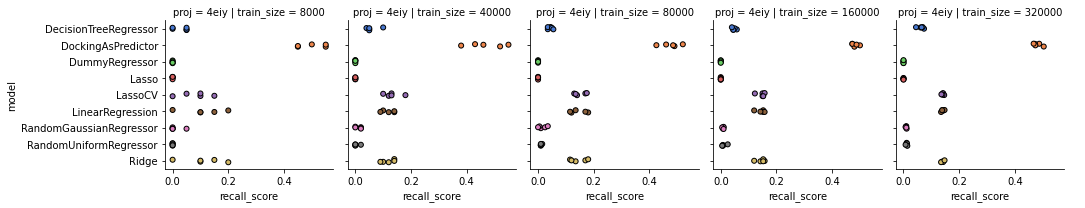

In [141]:
kwa = {
    'x': "recall_score", 
    'y': "model",
#     'orient':'h',
    'edgecolor':'k',
    'linewidth':1,
    'palette':'muted',
    'order':sorted(full_df.model.unique())    
}

grid = \
sns.FacetGrid(full_df, 
              col = "train_size", 
              row = "proj", 
              sharey=True, 
              sharex=True,
             )
(
    grid
    .map_dataframe(sns.stripplot, **kwa)
)

grid.add_legend()
plt.show()

# Plot recall for all available models

In [324]:
sort_order = {v:k for k, v in enumerate(regressors)}

def name2value(s: str) -> int:
    return sort_order.get(s, float('inf'))

df = (
    raw_data
    .drop('Unnamed: 0', axis=1)
    .dropna(axis=1)
    .pipe(threshold_to_int)
    .rename({'type':'model_type'}, axis=1)
    .query('model_type == "regressor"')
    .query('top_threshold == 1')
#     .query('train_size > 10_000')
#     .sort_values(['model','train_size'])
    .reset_index()
)
    
df = df.iloc[df['model'].map(name2value).sort_values().index]
df = df[df.model.isin(regressors)]

In [325]:
from itertools import chain

regressors = \
'''DecisionTreeRegressor
KNeighboursRegressor
RandomForestRegressor

LinearRegression
LassoCV
RidgeCV
LinearSVR

DockingAsPredictor
DummyRegressor
RandomGaussianRegressor
RandomUniformRegressor'''.split()

other_regressors = set(regressors) - set(df[~df['model'].isin(regressors)].model)

In [326]:
colors = sns.color_palette('colorblind',n_colors = len(regressors) + len(other_regressors))
palette = {tag:color for tag, color in zip(chain(regressors, other_regressors), colors)}

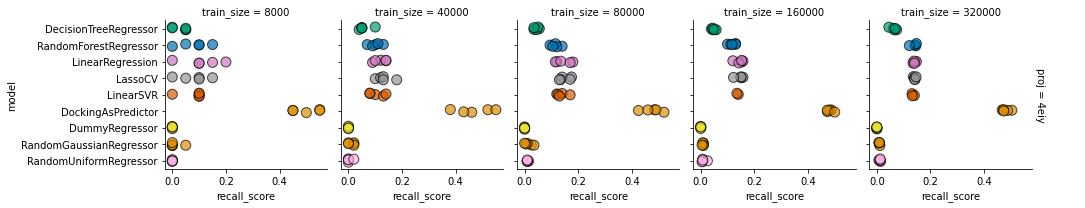

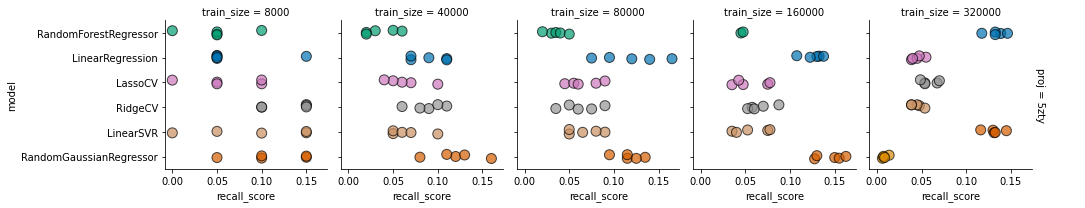

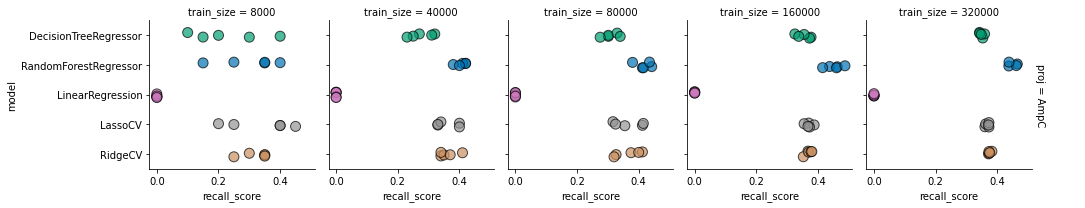

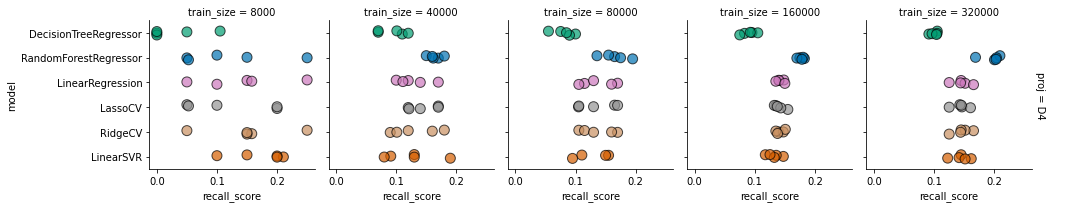

In [327]:
kwa = {
    'x': "recall_score", 
    'y': "model",
    'edgecolor':'k',
    'linewidth':1,
    'palette':palette,
    's':10,
    'alpha':0.7,
#     'order':sort_order
}

for proj in sorted(df.proj.unique()):
    subdf = df.query(f'proj == "{proj}"')
    grid = sns.FacetGrid(subdf, col='train_size', row='proj', margin_titles=True)
    grid.map_dataframe(sns.stripplot, **kwa,)
    grid.add_legend()

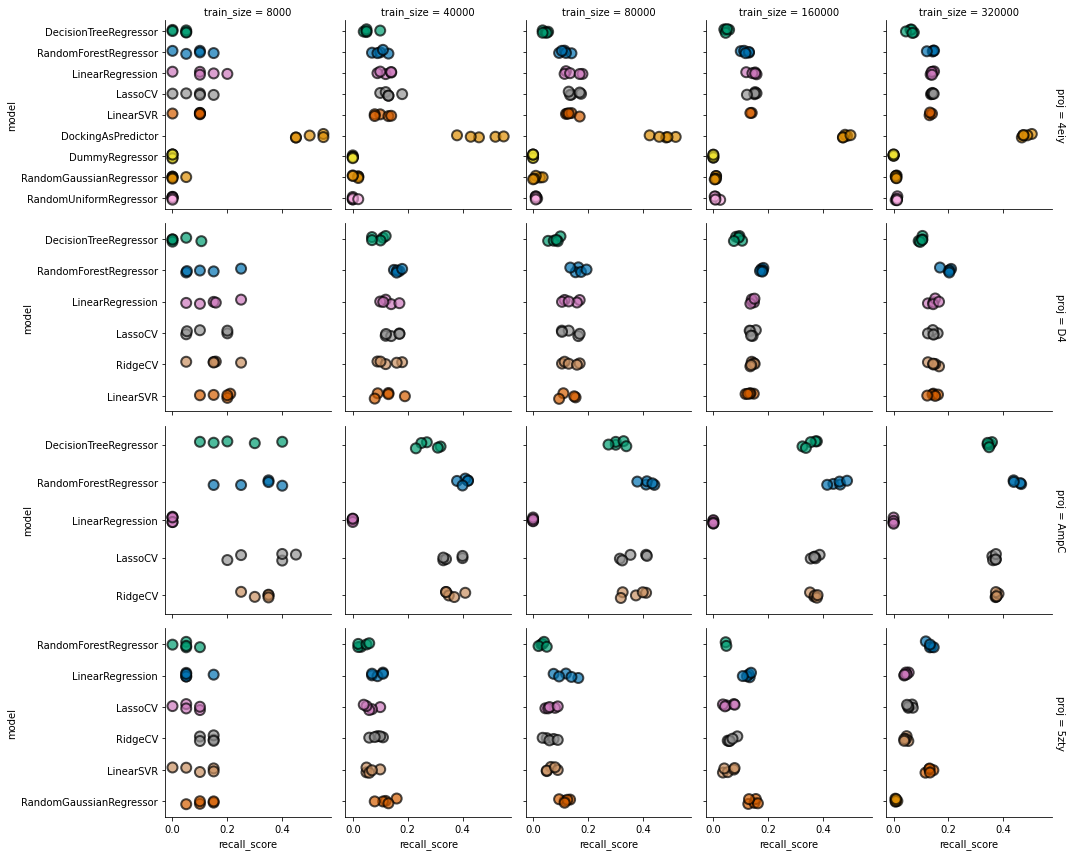

In [330]:
kwa = {
    'x': "recall_score", 
    'y': "model",
    'edgecolor':'k',
    'linewidth':2,
    'palette':palette,
    's':10,
    'alpha':0.7,
#     'order':sort_order
}

grid = sns.FacetGrid(
    df, 
    col = "train_size",
    row = "proj",
    margin_titles=True, 
    sharex=True, 
    sharey='row',
#     height=4, aspect=1.
)

grid.map_dataframe(sns.stripplot, **kwa,)
plt.savefig('../figures/Figure_4.png')

# Plot recall

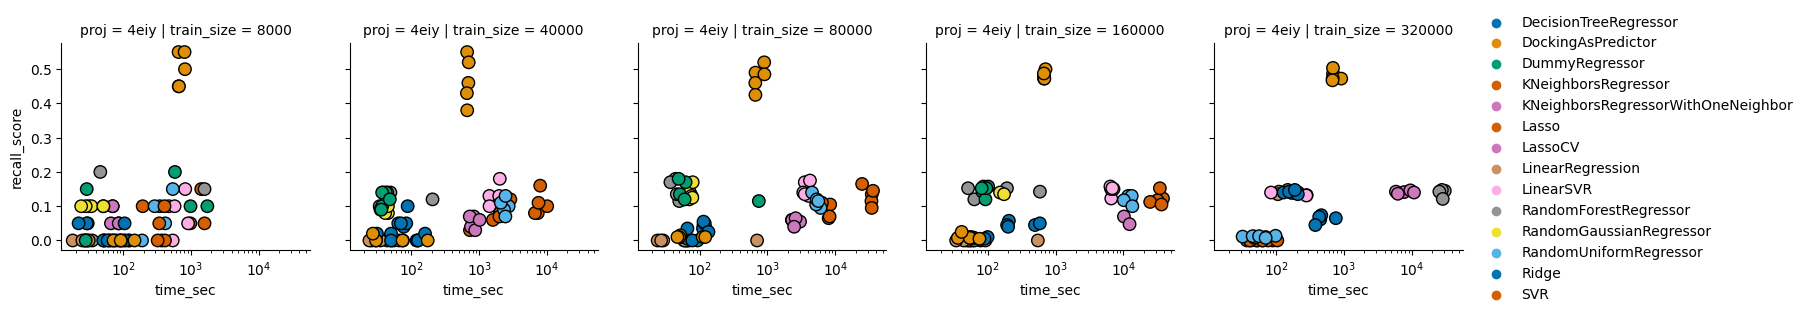

In [80]:
# methods_ordered = \
# [
#     'DecisionTreeRegressor',
#     'KNeighborsRegressor',
#     'RandomForestRegressor',
#     'LassoCV',
#     'LinearRegression',
#     'LinearSVR',
#     'RidgeCV',
#     'SVR'
# ]
# palette = sns.color_palette(palette='colorblind',n_colors = df.model.unique().size)
# colors = {m:c for m, c in zip(methods_ordered, palette)}

kwa = {
#     'x' : "log2_time_sec", 
    'x': 'time_sec',
    'y': "recall_score", 
    'hue': "model",
    'edgecolor':'k',
    'linewidth':1,
    's':80
    
}

grid = sns.FacetGrid(df, col = "train_size", row = "proj")
grid.map_dataframe(sns.scatterplot, **kwa, palette='colorblind').set(xscale = 'log')

grid.add_legend()
# plt.savefig('../figures/Figure_4.png')
plt.show()

# Plot ratio

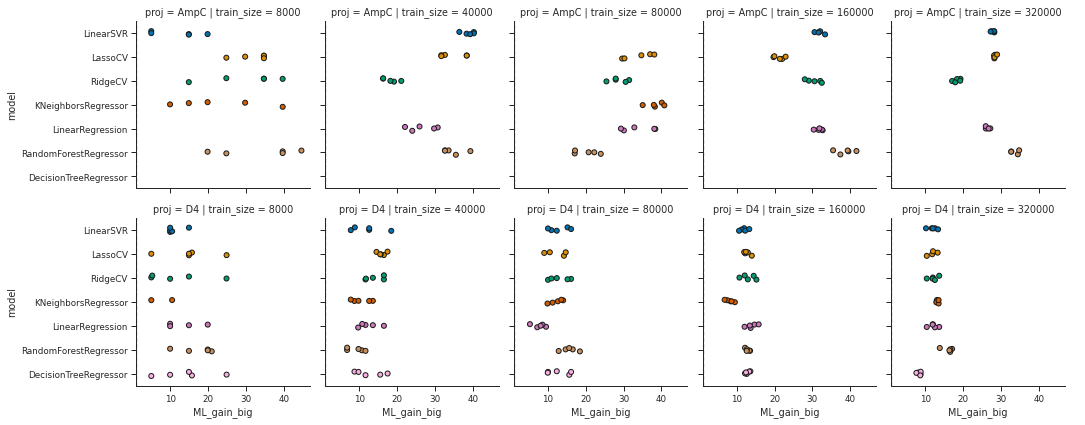

In [579]:
methods_ordered = \
[
    'DecisionTreeRegressor',
    'KNeighborsRegressor',
    'RandomForestRegressor',
    'LassoCV',
    'LinearRegression',
    'LinearSVR',
    'RidgeCV',
    'SVR'
]
palette = sns.color_palette(palette='colorblind',n_colors = df.model.unique().size)
colors = {m:c for m, c in zip(methods_ordered, palette)}

kwa = {
    'y': 'model',
    'x': "ML_gain_big", 
    'edgecolor':'k',
    'linewidth':1,
#     's':8,    
}

grid = sns.FacetGrid(df, col = "train_size", row = "proj")
(grid
 .map_dataframe(sns.stripplot, **kwa, palette='colorblind')
#  .set(xscale = 'log')
#  .set(yscale='log')
)

for ax in grid.axes.flat:
    ax.axvline(x=1.0, color='k', linestyle='--')
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    ax.set_xlim(1,None)
#     plt.setp(ax.get_yticklabels(), rotation=90)
    
grid.add_legend()
plt.savefig('../figures/Figure_4_gain.png')
plt.show()

# TODO: сделать разбивку по тому, на что тратится время

In [ ]:
def add_gain_with_extrapolation(df: pd.DataFrame) -> pd.DataFrame:
    # D4 from "Ultra-large for discovering chemotypes"
    # around 1s per ligand
    sec_per_ligand = 43_563*60*60 / 138_000_000 
    
    top_percentage = df.top_threshold / 100.
    
    # here we extrapolate recall to the rest of the dataset
    # among all ligands not yet docked, we predict top_percentage as hits,
    # and then recall_score of them are true ligands
    df['ligands_gained_only_with_ML'] = (df.N_ligands - df.docked)*top_percentage*df.recall_score
    df['ligands_gained_with_ML'] = df.ligands_gained_only_with_ML + df.docked*top_percentage    
    
    df['time_spent_for_ML'] = (0 
        + df.docked*sec_per_ligand  # docking of train set
        + df.time_sec  # train-predict loop
        + (df.N_ligands-df.docked)*top_percentage*sec_per_ligand  # docking of predicted top_threshold of ligands
                        )

    df['ligands_docked_if_we_did_docking'] = (time_spent_for_ML / sec_per_ligand)
    ligands_docked_if_we_did_docking = pd.concat([ligands_docked_if_we_did_docking, df.N_ligands], axis=1).min(axis=1)
    
    ligands_gained_with_docking = ligands_docked_if_we_did_docking*top_percentage
    
    df['ML_gain_big'] = ligands_gained_with_ML / ligands_gained_with_docking
    return df

In [583]:
df.sample().T

,431
model,LassoCV
model_type,regressor
top_threshold,1.0
train_size,160000
accuracy_score,0.982725
precision_score,0.135
recall_score,0.135338
TP+FP,400
docked,160400
time_sec,219


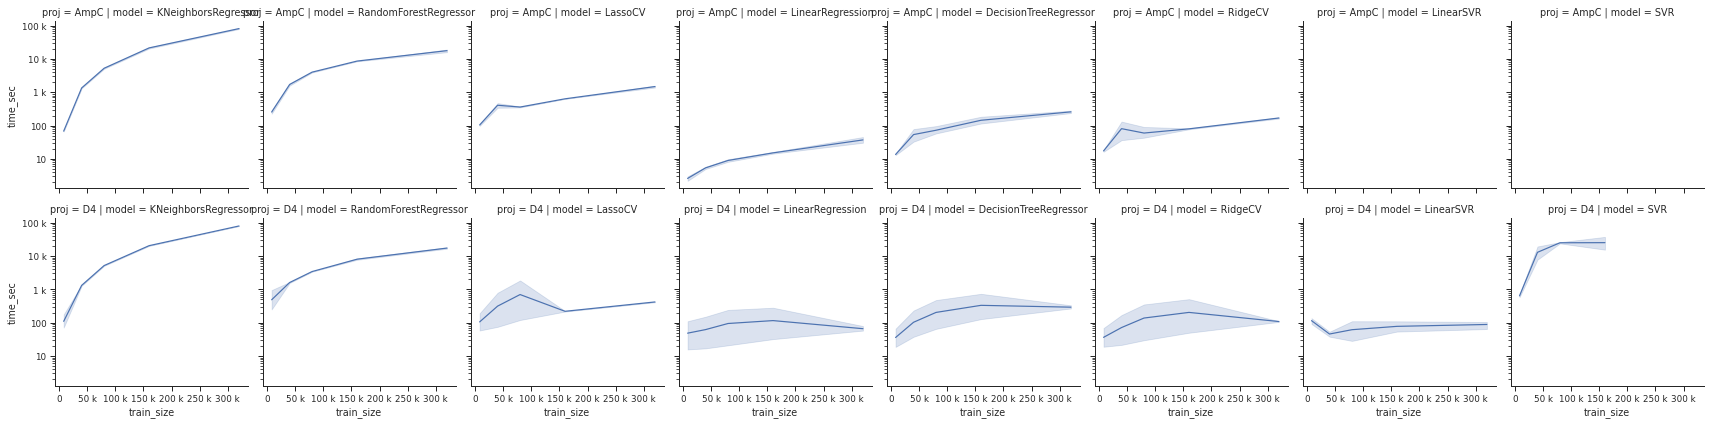

In [594]:
kwa = {
    'x': "train_size", 
    'y': 'time_sec',
#     'hue':'proj',
#     'edgecolor':'k',
#     'linewidth':1,
#     's':80
    
}

grid = sns.FacetGrid(df, row = "proj", col='model')
(
    grid
    .map_dataframe(sns.lineplot, **kwa, palette='colorblind')
    .set(yscale = 'log')
)

for ax in grid.axes.flat:
#     ax.axvline(x=1.0, color='k', linestyle='--')
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
#     ax.set_xlim(1,None)
#     plt.setp(ax.get_yticklabels(), rotation=90)

grid.add_legend()
# plt.savefig('../figures/Figure_4.png')
plt.show()

# Simulate gain for certain ML time and recall

In [516]:
sec_per_ligand = 43_563*60*60 / 138_000_000 

def add_gain_with_extrapolation(df: pd.DataFrame) -> pd.DataFrame:
    # D4 from "Ultra-large for discovering chemotypes"
    # around 1s per ligand
    sec_per_ligand = 1
    
    top_percentage = df.top_threshold / 100.
    
    # here we extrapolate recall to the rest of the dataset
    # among all ligands not yet docked, we predict top_percentage as hits,
    # and then recall_score of them are true ligands
    ligands_gained_only_with_ML = (df.N_ligands - df.docked)*top_percentage*df.recall_score
    ligands_gained_with_ML = ligands_gained_only_with_ML + df.docked*top_percentage    
    
    time_spent_for_ML = (0 
        + df.docked*sec_per_ligand  # docking of train set
        + df.time_sec  # train-predict loop
        + (df.N_ligands-df.docked)*top_percentage*sec_per_ligand  # docking of predicted top_threshold of ligands
                        )

    ligands_docked_if_we_did_docking = (time_spent_for_ML / sec_per_ligand)
    ligands_docked_if_we_did_docking = pd.concat([ligands_docked_if_we_did_docking, df.N_ligands], axis=1).min(axis=1)
    
    ligands_gained_with_docking = ligands_docked_if_we_did_docking*top_percentage
    
    df['ML_gain_big'] = ligands_gained_with_ML / ligands_gained_with_docking
    return df

In [536]:
test = pd.DataFrame(
    data = {\
            'top_threshold' : [1.0],
            'N_ligands' : [1e6],
            'docked' : [1_000],
            'recall_score' : [0.4],
            'time_sec': [3600]
           },
)
add_gain_with_extrapolation(test)

,top_threshold,N_ligands,docked,recall_score,time_sec,ML_gain_big
0,1.0,1000000.0,1000,0.4,3600,27.457162


In [543]:
def gain(recall, time):
    test = pd.DataFrame(
    data = {\
            'top_threshold' : [1.0],
            'N_ligands' : [1e6],
            'docked' : [1_000],
            'recall_score' : [recall],
            'time_sec': [time]
           },
    )
    rv = add_gain_with_extrapolation(test)
    return rv['ML_gain_big'].values[0]



In [573]:
times = np.linspace(1, 1e4, 50)
recalls = np.linspace(1, 0, 20)

gains = [
    [
        gain(r, t) for t in times
    ] 
    for r in recalls
]

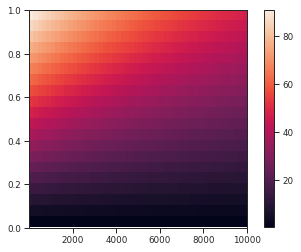

In [574]:
fig, ax = plt.subplots(1,1)

img = plt.imshow(gains)
xmin, xmax = times.min(), times.max()
ymin, ymax = recalls.min(), recalls.max()

ax.imshow(gains, 
          extent=[xmin, xmax, ymin, ymax],
          aspect = (xmax-xmin)/(ymax-ymin)
         )
plt.colorbar()